<a href="https://colab.research.google.com/github/Khaled-844AI/CarsClassifier/blob/main/CarsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import tensorflow_probability as tfp
from google.colab import drive
from tensorflow.keras.layers import Input , Layer, Dense, GlobalAveragePooling2D, BatchNormalization ,Resizing,Rescaling,Conv2D,MaxPooling2D,Flatten,RandomRotation, RandomFlip, RandomContrast, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import pathlib
from pathlib import Path
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import numpy as np

/tmp/ipython-input-443639144.py:15: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/My Drive/Cars'
files = os.listdir(folder_path)
files

['.ipynb_checkpoints', 'models', 'Cars']

In [4]:
len(os.listdir(os.path.join(folder_path , 'Cars')))

3

In [5]:
!cp -r '/content/drive/My Drive/Cars/Cars' '/content/data'


In [ ]:
!mkdir -p data/Cars/train
!mkdir -p data/Cars/test
!mkdir -p data/Cars/val

In [ ]:
!mkdir '/content/data/Cars/train/cheap Cars'
!mkdir '/content/data/Cars/train/modern Cars'
!mkdir '/content/data/Cars/train/old Cars'

!mkdir '/content/data/Cars/test/cheap Cars'
!mkdir '/content/data/Cars/test/modern Cars'
!mkdir '/content/data/Cars/test/old Cars'

!mkdir '/content/data/Cars/val/cheap Cars'
!mkdir '/content/data/Cars/val/modern Cars'
!mkdir '/content/data/Cars/val/old Cars'


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu , True)

In [ ]:
import os
import shutil
import numpy as np

# Ratios
train_ratio = 0.8
val_ratio = 0.10
test_ratio = 0.10

# Source folder
source_folder = '/content/drive/My Drive/Cars/all'

# Destination root folder
dest_root = '/content/data/Cars'

classes_map = {
    'cheap': 'cheap Cars',
    'modern': 'modern Cars',
    'old': 'old Cars'
}

# --- 1. Create destination folders ---
for split in ['train', 'val', 'test']:
    for cls in classes_map.values():
        os.makedirs(os.path.join(dest_root, split, cls), exist_ok=True)

# --- 2. Detect class from filename ---
def get_class_from_name(filename):
    name = filename.lower()
    if 'cheap' in name:
        return 'cheap Cars'
    if 'modern' in name:
        return 'modern Cars'
    if 'old' in name:
        return 'old Cars'
    return None  # if filename does not match any class

# --- 3. Collect files per class ---
files_by_class = {
    'cheap Cars': [],
    'modern Cars': [],
    'old Cars': []
}

for f in os.listdir(source_folder):
    cls = get_class_from_name(f)
    if cls:
        files_by_class[cls].append(f)

# --- 4. Shuffle & split per class ---
for cls, files in files_by_class.items():
    np.random.shuffle(files)
    total = len(files)

    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # --- 5. Move files ---
    for f in train_files:
        shutil.move(
            os.path.join(source_folder, f),
            os.path.join(dest_root, 'train', cls, f)
        )

    for f in val_files:
        shutil.move(
            os.path.join(source_folder, f),
            os.path.join(dest_root, 'val', cls, f)
        )

    for f in test_files:
        shutil.move(
            os.path.join(source_folder, f),
            os.path.join(dest_root, 'test', cls, f)
        )

print("✅ Dataset has been grouped & split successfully!")


✅ Dataset has been grouped & split successfully!


In [6]:
img = cv2.imread(os.path.join('/content/data/Cars/test' , 'modern Cars' , 'train_modern_Cars_2024-chevy-blazer-ev-suv-westbrook-5.png'))
img.shape

(900, 1600, 3)

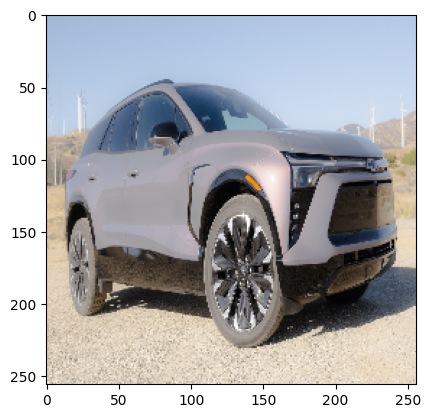

In [7]:
img_resized = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

In [8]:
train_directory = '/content/data/Cars/train'
val_directory = '/content/data/Cars/val'
test_directory = '/content/data/Cars/test'

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 1222 files belonging to 3 classes.


In [10]:
val_data = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 152 files belonging to 3 classes.


In [11]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=['cheap Cars','modern Cars', 'old Cars'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 155 files belonging to 3 classes.


In [12]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025 , 0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(256 , 256),
    Rescaling(1./255)
])

In [14]:
def augment_layer(image , label):
  return augment_layers(image , training = True), label

In [15]:
def box(lamda):

    r_x = tf.cast(tfp.distributions.Uniform(0 , 256).sample(1)[0] , dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0 , 256).sample(1)[0] , dtype = tf.int32)

    r_w = tf.cast(256*tf.math.sqrt(1 - lamda) , dtype = tf.int32)
    r_h = tf.cast(256*tf.math.sqrt(1 - lamda) , dtype = tf.int32)

    r_x = tf.clip_by_value( r_x - r_w//2 ,0 , 256)
    r_y = tf.clip_by_value( r_y - r_h//2 ,0 , 256)

    x_b_r = tf.clip_by_value( r_x + r_w//2 ,0 , 256)
    y_b_r = tf.clip_by_value( r_y + r_h//2 ,0 , 256)

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y , r_x , r_h , r_w

In [16]:
def cutmix(train_dataset1 , train_dataset2):
    (image_1 , label1) , (image_2 , label2) = train_dataset1 , train_dataset2

    lamda = tfp.distributions.Beta(0.2 , 0.2).sample(1)[0]


    r_y , r_x , r_h , r_w = box(lamda)

    crop2 = tf.image.crop_to_bounding_box(image_2 , r_y , r_x , r_h , r_w)
    pad2 = tf.image.pad_to_bounding_box(crop2 , r_y , r_x , 256 , 256)

    crop1 = tf.image.crop_to_bounding_box(image_1 , r_y , r_x , r_h , r_w)
    pad1 = tf.image.pad_to_bounding_box(crop1 , r_y , r_x , 256 ,256)

    image = image_1 - pad1 + pad2

    lamda = tf.cast(1 - (r_h * r_w)/(256 * 256) , dtype = tf.float32)

    label = lamda * tf.cast(label1, dtype = tf.float32) + (1 - lamda) * tf.cast(label2, dtype = tf.float32)

    return image , label

In [17]:
train_dataset1 = train_data.map(augment_layer , num_parallel_calls = tf.data.AUTOTUNE)
train_dataset2 = train_data.map(augment_layer , num_parallel_calls = tf.data.AUTOTUNE)

mix_data = tf.data.Dataset.zip((train_dataset1 , train_dataset2))

In [18]:
trainning_data = mix_data.map(cutmix , num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_data = val_data.prefetch(tf.data.AUTOTUNE)

In [19]:
validation_data = val_data.prefetch(tf.data.AUTOTUNE)

In [28]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

backbone = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

# Freeze backbone
backbone.trainable = False

model = Sequential([
    Input(shape=(256,256,3)),

    # EfficientNet preprocessing
    Lambda(preprocess_input),

    backbone,
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax'),
])



82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [29]:
checkpoint = ModelCheckpoint(
    'best_weights.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [30]:
loss_function = CategoricalCrossentropy()

In [31]:
metrics = [CategoricalAccuracy(name = 'accuracy') , TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]

In [32]:
lr = 0.001
model.compile(
    optimizer = Adam(lr),
    loss=loss_function,
    metrics=metrics
)

In [33]:
history = model.fit(
    train_data,
    epochs = 60,
    validation_data = validation_data,
    verbose = 1,
    callbacks = [checkpoint]
    )

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6986 - loss: 0.8174 - top_k_accuracy: 0.8970   
Epoch 1: val_accuracy improved from -inf to 0.90132, saving model to best_weights.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7011 - loss: 0.8099 - top_k_accuracy: 0.8982 - val_accuracy: 0.9013 - val_loss: 0.3982 - val_top_k_accuracy: 0.9934
Epoch 2/60
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9053 - loss: 0.2328 - top_k_accuracy: 0.9892
Epoch 2: val_accuracy improved from 0.90132 to 0.94737, saving model to best_weights.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 264ms/step - accuracy: 0.9053 - loss: 0.2330 - top_k_accuracy: 0.9893 - val_accuracy: 0.9474 - val_loss: 0.2809 - val_top_k_accuracy: 0.9934
Epoch 3/60
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9339 - loss: 0.2015 - top_k_accuracy: 0.9886
Epoch 3: val_accuracy did not improve from 0.94737
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9336 - loss: 0.2018 - top_k_accuracy: 0.

In [34]:
model.save('Carsmodel.keras')


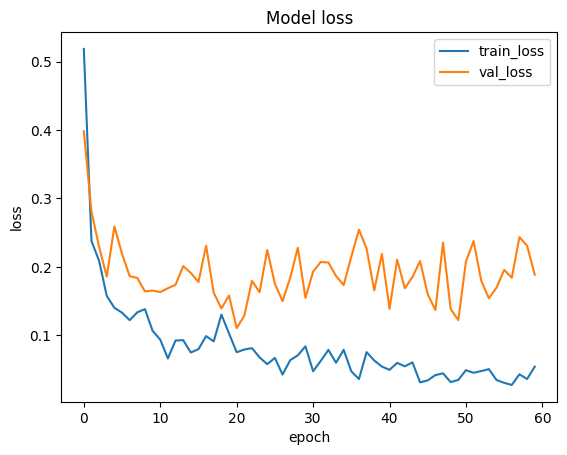

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [36]:
model.load_weights('best_weights.keras')

# Save model architecture and weights in a single .pkl file
model_config = model.to_json()  # Get model architecture as JSON
model_weights = model.get_weights()  # Get model weights

data = {
    'model_config': model_config,
    'model_weights': model_weights
}

with open('model.pkl', 'wb') as f:
    pickle.dump(data, f)

NameError: name 'pickle' is not defined

In [37]:
model.load_weights('best_weights.keras')
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9498 - loss: 0.2930 - top_k_accuracy: 0.9870


[0.2067066878080368, 0.9612902998924255, 0.9935483932495117]

In [ ]:
drive.mount('/content/data')

Mounted at /content/data


In [38]:
!cp -r '/content/Carsmodel.keras' '/content/drive/MyDrive/Cars/models'

In [39]:
!cp -r '/content/best_weights.keras' '/content/drive/MyDrive/Cars/models'

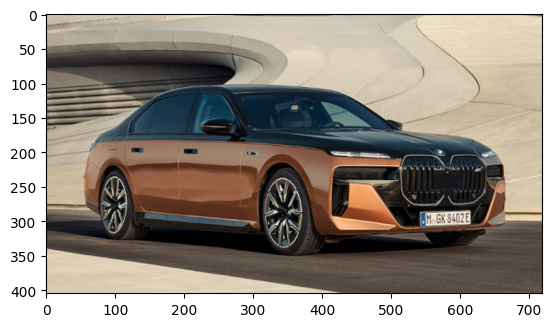

In [ ]:
img = cv2.imread('/content/bmw-i7-m70-front-720x405px.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
img.shape

(405, 720, 3)

In [ ]:
model = tf.keras.models.load_model('Carsmodel.keras')

model.load_weights('best_weights.keras')

img_resized = np.expand_dims(img, axis=0)

predictions = model.predict(img_resized)

print(predictions)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import shutil
import os

source = "/content/data/Cars"
destination_root = "/content/drive/MyDrive"
destination = os.path.join(destination_root, "Cars")

# Create /content/drive if it doesn't exist
os.makedirs(destination_root, exist_ok=True)

# Move the entire Cars folder
shutil.move(source, destination)

print("✅ Folder moved to /content/drive/Cars")


✅ Folder moved to /content/drive/Cars
